<a href="https://colab.research.google.com/github/GaborVxxx/ml_notes/blob/main/Test2_multi_label_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
!python3 --version

Python 3.10.12


In [74]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel, AdamW, get_scheduler
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, hamming_loss, precision_score, recall_score
# Use progress bar
from tqdm.auto import tqdm
from collections import Counter


# Hyperparameters
learning_rate = 2e-5  # Adjust if needed
batch_size = 16     # Adjust if needed
dropout_rate = 0.2   # Adjust dropout rate (0.1 - 0.5 usually work well)
random_seed = 42    # Adjust random seed for reproducibility
epochs = 10
threshold_list = [0.5, 0.7, 0.9]  # Adjust threshold values as needed
patience_to_not_improve = 5

class TreeClassifier(nn.Module):
    def __init__(self, num_classes, dropout_rate):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        # self.dropout = nn.Dropout(dropout_rate) # Dropout layer NOTE : not in use jet the data set is to small
        self.fc = nn.Linear(768, num_classes)  # Adjust input size if using different embeddings

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output  # [CLS] token representation
        # pooled_output = self.dropout(pooled_output) # Apply dropout NOTE : not in use jet the data set is to small
        logits = self.fc(pooled_output)
        probabilities = torch.sigmoid(logits)  # Apply sigmoid for multi-label classification
        return probabilities

In [75]:
# UTILS
from timeit import default_timer as timer

def print_train_time(start, end, device=None):
    """ Print traing time """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

def getResponse(predicted_labels, threshold):
    """ Print out message """
    if len(predicted_labels) == 0:
      return f"Im not able to confidently answer... sorry. Can you try to rephrase? (trashold: {threshold})"
    else:
      return f" ".join([label_names[i] for i in predicted_labels]) + f" (trashold: {threshold})"

In [76]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [77]:
# Define Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [78]:
"""
label_names = [
    "R0",
    "B1","B2","B3","B4","B5","B7","B8","B9",
    "P1","P2","P3","P4","P13","P14","P15","P16",
    "Y1","Y2","Y3","Y4","Y5","Y6","Y19","Y20","Y21","Y22","Y23","Y24","Y25","Y26","Y27","Y28","Y29","Y30",
    "G1","G2","G3","G4"
]
"""

label_names = [
    "R0",
    "B5",
]

text_examples = [
    {"text": "I like to start a mixer", "labels": ["R0"]},
    {"text": "I like to change my chart to a mixer chart", "labels": ["R0"]},
    {"text": "Mixer", "labels": ["R0"]},
    {"text": "I don't want a simple chart", "labels": ["R0"]},
    {"text": "I like to have multiple chart together in one", "labels": ["R0"]},
    {"text": "I like to combine multiple charts", "labels": ["R0"]},
    {"text": "I like to have a gauge", "labels": ["B5"]},
    {"text": "I need a gauge", "labels": ["B5"]},
    {"text": "Gauge.", "labels": ["B5"]},
    {"text": "Progress line", "labels": ["B5"]},
    {"text": "Progress bar", "labels": ["B5"]},
    {"text": "line", "labels": ["B5"]},
    {"text": "I like to have a line", "labels": ["B5"]},
]

texts = [example["text"] for example in text_examples]

labels = [[1 if label in example["labels"] else 0 for label in label_names] for example in text_examples]

labels = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=random_seed)

In [79]:

# Calculate frequency of each label
label_count = Counter()
for example in text_examples:
    for label in example["labels"]:
        label_count[label] += 1

# Calculate class weights
num_samples = len(text_examples)
class_weights = {}
for label, count in label_count.items():
    # You can adjust the formula to suit your needs
    weight = num_samples / (len(label_names) * count)  # Inverse frequency
    class_weights[label] = weight

# Convert class_weights to a tensor
class_weights_tensor = torch.tensor([class_weights[label] if label in class_weights else 1.0 for label in label_names])
class_weights_tensor = class_weights_tensor.to(device)
print(class_weights_tensor)


tensor([1.0833, 0.9286])


In [80]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
dataset = TextDataset(X_train, y_train, tokenizer, max_len=128)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [81]:
test_dataset = TextDataset(X_test, y_test, tokenizer, max_len=128)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

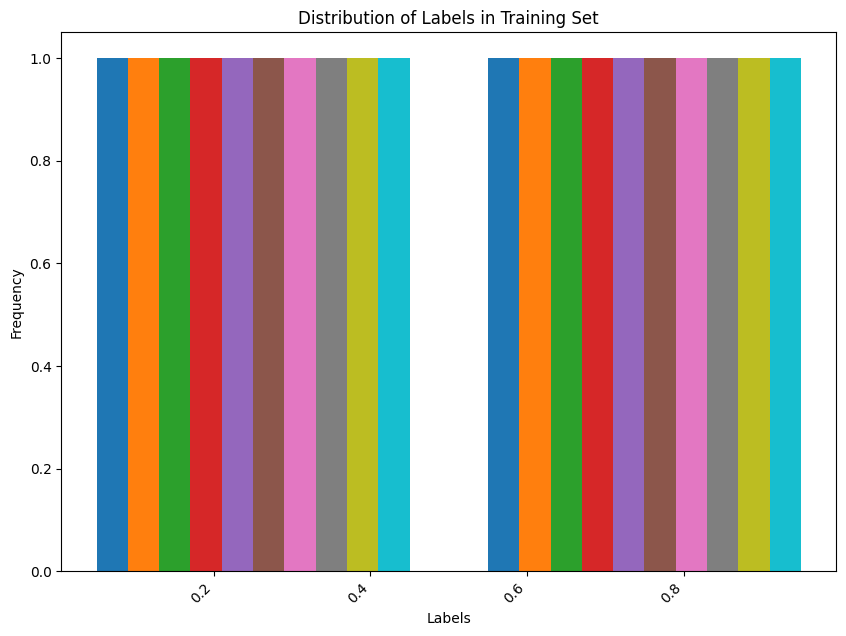

In [82]:
# Plot the data
plt.figure(figsize=(10, 7))

# Convert y_train to a list of tuples for hashability
y_train_hashable = [tuple(row) for row in y_train]

plt.hist(y_train_hashable, bins=len(set(y_train_hashable)))  # Plot histogram of labels
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Distribution of Labels in Training Set')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

plt.show()

In [83]:
# Early Stopping Parameters
best_val_loss = float('inf')  # Initialize with a very large value
patience = patience_to_not_improve  # Number of epochs to wait for improvement
epochs_without_improvement = 0

In [84]:
# Example Usage
model = TreeClassifier(num_classes=len(label_names), dropout_rate=dropout_rate).to(device)
#criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
criterion = nn.BCEWithLogitsLoss(weight=class_weights_tensor)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = AdamW(model.parameters(), lr=5e-5)

total_steps = len(data_loader) * epochs
print(f"Total training steps: {total_steps}")

# Configure the scheduler
scheduler = get_scheduler(
    name="linear",  # Linear learning rate decay
    optimizer=optimizer,
    num_warmup_steps=100,  # Warmup steps (adjust based on your dataset)
    num_training_steps=total_steps
)

start = timer()

for epoch in tqdm(range(epochs)):
    model.train()  # Set the model to training mode
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in data_loader:
        # Retrieve data from batch
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Forward pass: Get predictions from the model
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)  # Shape: [batch_size, num_classes]

        # Collect predictions and true labels
        # Convert model outputs to multi-label predictions using a threshold
        threshold = 0.5  # Adjust as needed
        preds = (outputs > threshold).cpu().numpy()  # Apply threshold to get multi-label predictions
        all_preds.extend(preds)  # Store all predictions
        all_labels.extend(labels.cpu().numpy())  # Store all true labels

        # Compute loss
        loss = criterion(outputs, labels.float())

        # Backward pass: Optimize the model
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()        # Compute gradients
        optimizer.step()       # Update weights

        # Update the scheduler
        scheduler.step()

        total_loss += loss.item()

    # Calculate overall accuracy for the epoch
    #epoch_accuracy = compute_accuracy(all_labels, all_preds)
    epoch_hamming_loss = hamming_loss(all_labels, all_preds)

    # Logging the loss and accuracy for this epoch
    avg_loss = total_loss / len(data_loader)
    if (epoch + 1) % 1 == 0:  # print every epoch (adjust the '1' to control frequency)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, Hamming Loss: {epoch_hamming_loss:.4f}")

    # Validation Phase (Calculate val_loss)
    model.eval()
    val_loss = 0  # Initialize validation loss
    with torch.no_grad():
        for val_batch in data_loader:
            input_ids = val_batch['input_ids'].to(device)
            attention_mask = val_batch['attention_mask'].to(device)
            labels = val_batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            # Compute loss
            loss = criterion(outputs, labels.float())
            val_loss += loss.item()

    val_loss /= len(data_loader)  # Average validation loss
    print(f"Validation Loss: {val_loss:.4f}")  # Print validation loss

    # Early Stopping Check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        # Save the model's state_dict (optional)
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping triggered.")
            break


end = timer()
print_train_time(start, end, device)

Total training steps: 10


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10, Loss: 0.7333, Hamming Loss: 0.5000
Validation Loss: 0.7322
Epoch 2/10, Loss: 0.7283, Hamming Loss: 0.5000
Validation Loss: 0.7321
Epoch 3/10, Loss: 0.7334, Hamming Loss: 0.5000
Validation Loss: 0.7319
Epoch 4/10, Loss: 0.7310, Hamming Loss: 0.5000
Validation Loss: 0.7317
Epoch 5/10, Loss: 0.7294, Hamming Loss: 0.5000
Validation Loss: 0.7313
Epoch 6/10, Loss: 0.7317, Hamming Loss: 0.5000
Validation Loss: 0.7309
Epoch 7/10, Loss: 0.7280, Hamming Loss: 0.5000
Validation Loss: 0.7304
Epoch 8/10, Loss: 0.7295, Hamming Loss: 0.5000
Validation Loss: 0.7298
Epoch 9/10, Loss: 0.7297, Hamming Loss: 0.5000
Validation Loss: 0.7290
Epoch 10/10, Loss: 0.7284, Hamming Loss: 0.5000
Validation Loss: 0.7282
Train time on cpu: 223.696 seconds


223.69575814300015

In [85]:
def predict_single_text(model, tokenizer, text, device, max_len=128, threshold=0.5):
    model.eval()
    with torch.no_grad():
        # Tokenize input text
        encoding = tokenizer(
            text,
            max_length=max_len,
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        # Get predictions
        output = model(input_ids=input_ids, attention_mask=attention_mask)
        probabilities = output.cpu().numpy()[0]
        predicted_labels = [i for i, prob in enumerate(probabilities) if prob > threshold]

    return predicted_labels, probabilities

# Example Usage
texts = ["mixer", "line"]
for text in texts:
  thresholds = threshold_list
  for threshold in thresholds:
    predicted_labels, probabilities = predict_single_text(model, tokenizer, text, device, threshold=threshold)
    print(f"Threshold: {threshold}, Predicted Labels: {[label_names[i] for i in predicted_labels]}, Probabilities: {probabilities}")
    #print(getResponse(predicted_labels, threshold))


Threshold: 0.5, Predicted Labels: ['B5'], Probabilities: [0.43467605 0.61438626]
Threshold: 0.7, Predicted Labels: [], Probabilities: [0.43467605 0.61438626]
Threshold: 0.9, Predicted Labels: [], Probabilities: [0.43467605 0.61438626]
Threshold: 0.5, Predicted Labels: ['B5'], Probabilities: [0.44697267 0.5863239 ]
Threshold: 0.7, Predicted Labels: [], Probabilities: [0.44697267 0.5863239 ]
Threshold: 0.9, Predicted Labels: [], Probabilities: [0.44697267 0.5863239 ]
